In [1]:
import sys, os, cv2, json
import seaborn as sns
import pandas as pd, numpy as np, datetime as dt, matplotlib.pyplot as plt, pytz
from tqdm import tqdm
from itertools import combinations
import matplotlib.lines as mlines

In [2]:
from astral.sun import sun # https://astral.readthedocs.io/en/latest/
from astral import LocationInfo
stgallen_city = LocationInfo('St. Gallen', 'Switzerland', 'Europe/Zurich', 47.224492554512014, 9.376722938498643)

In [3]:
import scienceplots
import matplotlib.ticker as ticker
plt.style.use(['science'])
FIG_WIDTH = 7.5  # width of figure in inches (a4 width)
TARGET_FOLDER = "/home/masc12/dev/masc12-mthesis/eda/img-eda/plots"

In [4]:
webcams = ['altenrhein', 'ebenalp', 'golfclub-erlen', 'kronberg', 'romanshorn', 'rorschacherberg', 'sitterdorf', 'wiler-turm']
wbc_cmap = json.loads(open('webcam_colormap.json').read())

In [5]:
df_all_images = pd.DataFrame()
for wbc in webcams:
    img_files = os.listdir(f"../../data/{wbc}")
    img_ts = [dt.datetime.strptime(img.split(".")[0], "%Y-%m-%d_%H-%M-%S") for img in img_files]
    img_ts = [pytz.timezone('Europe/Zurich').localize(ts) for ts in img_ts]
    img_files = pd.DataFrame({"filename": img_files, "timestamp": img_ts, "webcam": wbc})
    img_files.sort_values("timestamp", inplace=True)
    img_files.reset_index(drop=True, inplace=True)
    df_all_images = pd.concat([df_all_images, img_files])

# Calculate earliest/latest image start/end

In [6]:
def  get_date_range_from(start, end):
    daterange = []
    while start <= end:
        daterange.append(start)
        start += dt.timedelta(minutes=10)
    return daterange

In [7]:
earliest_img_start = df_all_images.groupby("webcam")["timestamp"].min().min()
latest_img_end     = df_all_images.groupby("webcam")["timestamp"].max().max()
earliest_img_start, latest_img_end

(Timestamp('2024-02-12 08:00:00+0100', tz='Europe/Zurich'),
 Timestamp('2025-03-14 15:10:00+0100', tz='Europe/Zurich'))

In [8]:
latest_img_start = df_all_images.groupby("webcam")["timestamp"].min().max()
earliest_img_end = df_all_images.groupby("webcam")["timestamp"].max().min()
latest_img_start, earliest_img_end

(Timestamp('2024-09-19 14:10:00+0200', tz='Europe/Zurich'),
 Timestamp('2025-03-14 12:10:00+0100', tz='Europe/Zurich'))

In [9]:
common_range_10min = get_date_range_from(latest_img_start, earliest_img_end)
total_range_10min = get_date_range_from(earliest_img_start, latest_img_end)

# Filter by Sunset/Sunrise

In [10]:
fetch_sun_times = lambda date: sun(stgallen_city.observer, date, tzinfo=stgallen_city.timezone)

In [11]:
def filter_dusk_dawn(daterange):
    new = []
    for x in daterange:
        sun_times = fetch_sun_times(x)
        if sun_times['dawn'] <= x <= sun_times['dusk']:
            new.append(x)
    return new

In [12]:
common_filtered_range_10min = filter_dusk_dawn(common_range_10min)
total_filtered_range_10min = filter_dusk_dawn(total_range_10min)

In [13]:
df_common = df_all_images[df_all_images["timestamp"].isin(common_filtered_range_10min)]
df_total = df_all_images[df_all_images["timestamp"].isin(total_filtered_range_10min)]

In [14]:
print(f"{len(df_all_images)} total images.")
print(f"{len(df_total)} total images during daylight hours (dawn to dusk)")
print(f"{len(df_common)} common images (all webcams have images in this interval)")

142123 total images.
119383 total images during daylight hours (dawn to dusk)
82893 common images (all webcams have images in this interval)


In [15]:
total_range_daily = pd.date_range(
    earliest_img_start,
    latest_img_end
)

dusk_dawn_df = pd.DataFrame({
    "ts": [x.date() for x in total_range_daily],
    "dusk": [pd.to_datetime(fetch_sun_times(x)["dusk"]) for x in total_range_daily],
    "dawn": [pd.to_datetime(fetch_sun_times(x)["dawn"]) for x in total_range_daily]
})

# First & Last (per day)

In [16]:
firstimgperday = df_all_images.groupby([df_all_images.timestamp.dt.date, df_all_images.webcam])["timestamp"].min()
lastimgperday = df_all_images.groupby([df_all_images.timestamp.dt.date, df_all_images.webcam])["timestamp"].max()

<Figure size 350x262.5 with 0 Axes>

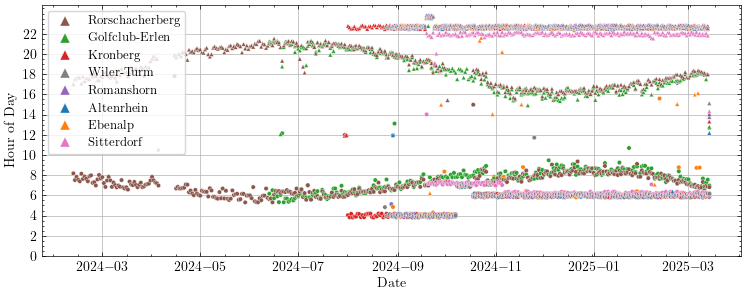

In [20]:
# Convert Series to DataFrame and rename the column
df_firstimg = firstimgperday.rename("first_timestamp").reset_index()
df_lastimg = lastimgperday.rename("last_timestamp").reset_index()

# Extract time for y-axis
df_firstimg["first_time"] = (
    df_firstimg["first_timestamp"].dt.hour +
    df_firstimg["first_timestamp"].dt.minute / 60
)

df_lastimg["last_time"] = (
    df_lastimg["last_timestamp"].dt.hour +
    df_lastimg["last_timestamp"].dt.minute / 60
)

# add y jtter
df_firstimg["first_time"] = df_firstimg["first_time"] + np.random.uniform(-0.2, 0.2, len(df_firstimg))
df_lastimg["last_time"] = df_lastimg["last_time"] + np.random.uniform(-0.2, 0.2, len(df_lastimg))


plt.clf()
plt.figure(figsize=(FIG_WIDTH, 3))

sns.scatterplot(
    data=df_firstimg,
    x="timestamp",  # Date on x-axis
    y="first_time",  # Time on y-axis
    hue="webcam",
    palette=wbc_cmap,
    marker="o",
    s=10,

)

sns.scatterplot(
    data=df_lastimg,
    x="timestamp",  # Date on x-axis
    y="last_time",  # Time on y-axis
    hue="webcam",
    palette=wbc_cmap,
    marker="^",
    s=10,
)


# Formatting
plt.xticks()
plt.xlabel("Date")
plt.ylabel("Hour of Day")
plt.yticks(
    np.arange(0, 24, 2),
    [f"{int(x)}" for x in np.arange(0, 24, 2)],
)
# plt.title("First and Last Image per Day")

plt.grid(True)
plt.gca().set_axisbelow(True)

# only show one legend
handles, labels = plt.gca().get_legend_handles_labels()
# increase handle size
by_label = dict(zip(labels, handles))
plt.legend(
    by_label.values(), 
    [x.title() for x in by_label.keys()], 
    frameon=True, 
    fontsize=9, 
    loc='upper left',
    markerscale=2.5      # Scales the marker size in the legend
)

plt.tight_layout(pad=0.5)
plt.savefig(f"{TARGET_FOLDER}/over-time-first-last.png", dpi=300)
plt.show()